In [1]:
#Importing phydrus
#get libraries
import os

import phydrus as ps

import pandas as pd

import numpy as np

In [37]:
#Doing working directory stuff

#set working directory manually (I'm sure there is a better way to do this)
os.chdir('C:\\Users\\meghanrobinson\\Downloads\\Modeling\\PHydrusTest\\PipelineStructure')

#give path to exe file
exe = os.path.join(os.getcwd(), "2_Code", "H1D_CALC.EXE")

#name the folder files will fill
ws = os.path.join(os.getcwd(), '3_Results', 'Python_RBundle_12-16')

'C:\\Users\\meghanrobinson\\Downloads\\Modeling\\PHydrusTest\\PipelineStructure\\3_Results\\Python_RBundle_12-16'

In [147]:
#temporary, looking at how Model function works
import inspect
#lines= inspect.getsource(ml.simulate)
#print(lines)

lines= inspect.getsource(ml.write_input)
print(lines)


    def write_input(self):
        """Method to write the input files for the HYDRUS-1D simulation."""
        # 1. Write SELECTOR.IN
        self.write_selector()

        # 2. Write PROFILE.DAT
        self.write_profile()

        # 3. Write ATMOSPH.IN
        if self.basic_info["AtmInf"]:
            self.write_atmosphere()



In [139]:
#this is a dataframe for soil materials, n=1 is number of materials
m = ml.get_empty_material_df(n=1)

#these are vg parameters for each depth
vgs_use
vglist = list(vgs_use)
vglist
m.loc[1] = vglist
m

water                                   
      thr     ths    Alfa       n    Ks    l
1  0.0792  0.4418  0.0158  1.4145  8.18  0.5

In [200]:
#read in csvs

#Atmospheric Input
atm = pd.read_csv(os.path.join(os.getcwd(), '1_Input', 'AtmosphBoundary.csv'))
days = len(atm['date']) #save length of days column for later steps

#create new dataframe to manipulate to be exactly what is needed for PHydrus (keeping old version w/ temperature info for now)
atm2 = atm.drop(columns=['date','temp.mean.agr_c', 'min_temp_c', 'max_temp_c'], axis=1)

#these are required column names: 'tAtm', 'Prec', 'rSoil', 'rRoot', 'hCritA', 'rB', 'hB', 'hT'
atm2 = atm2.rename(columns={'Unnamed: 0':'tAtm', 'pet_mm':'rSoil', 'precip_mm':'Prec'})
atm2['rRoot'] = 0
atm2['hCritA']= 1000000
atm2['rB']= 0
atm2['hB']= 0
atm2['hT']= 0

#rearrange to match format input
atm2 = atm2[['tAtm', 'Prec', 'rSoil', 'rRoot', 'hCritA', 'rB', 'hB', 'hT']]

#Van Genuchten parameters
vgs = pd.read_csv(os.path.join(os.getcwd(), '1_Input', 'VGParams.csv'))
vgs_use= vgs.iloc[0, [2,3,4,5,6,7]]
vglist = list(vgs_use)

#Observation Nodes
obs = pd.read_csv(os.path.join(os.getcwd(), '1_Input', 'ObservationInput.csv'))
obspts = obs.iloc[:, 2]
obslist = list(obspts)

#Timestep list 
timesteps = [0.4]
timesteps2 = [0.4, 0.001, 0.003, 0.005, 0.006, 0.0001, 0.0003, 0.0004, 0.01, 0.00002,
             0.00003, 0.00004, 0.00005, 0.00006, 0.00007, 0.00009, 0.0002, 0.0007, 0.0009,
             0.0055, 0.0065, 0.00015, 0.00055, 0.00095]

INFO: Directory C:\Users\meghanrobinson\Downloads\Modeling\PHydrusTest\PipelineStructure\3_Results\Python_RBundle_12-16 created
INFO: Successfully wrote C:\Users\meghanrobinson\Downloads\Modeling\PHydrusTest\PipelineStructure\3_Results\Python_RBundle_12-16\SELECTOR.IN
INFO: Successfully wrote C:\Users\meghanrobinson\Downloads\Modeling\PHydrusTest\PipelineStructure\3_Results\Python_RBundle_12-16\PROFILE.DAT
INFO: Successfully wrote C:\Users\meghanrobinson\Downloads\Modeling\PHydrusTest\PipelineStructure\3_Results\Python_RBundle_12-16\ATMOSPH.IN
INFO: Hydrus-1D Simulation Successful.
C:\Users\meghanrobinson\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\phydrus\read.py:214: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = read_csv(file, skiprows=s, nrows=e - s - 2, usecols=usecols,
C:\Users\meghanrobinson\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\phydrus\read.p

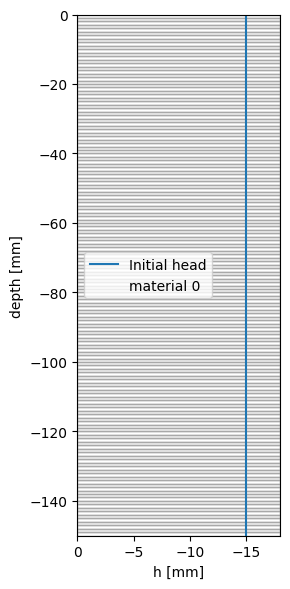

In [204]:
#Do model run

#loop iterating through time steps

for i in range(len(timesteps2)):
    #basic model info (name, units)
    ml = ps.Model(exe_name=exe, #telling it to use single porosity exe
              ws_name=ws, #folder to create/fill (in 3_Results)
              name="model",
              mass_units="mmol", time_unit="days", length_unit="mm")
    #add time info
    times = ml.add_time_info(tinit=0, #first day
                         tmax=days, #last day
                         print_times=True, #true if want model to print t level info every day
                        # printinit= 1,
                         #printmax= 40,
                         #dtprint= 1,
                         dt=timesteps2[i], #initial time increment (this is what R iteratres through)
                         dtmax=0.5, #max time increment (didn't change)
                         #printinit=120 #this would specify when to start printing t level info
                        )
    
    #add atmosphere input to Hydrus?
    ml.add_atmospheric_bc(atm2)
    
    #add waterflow information for selector on model type, boundary conditions, can add groundwater here (didn't)
    ml.add_waterflow(model= 0, #single porosity
                 top_bc=3, #top boundary condition is atmospheric with runoff
                 bot_bc=4, #bottom boundary condition is free drainage
                 )
    
    #this is a dataframe for soil materials, n=1 is number of materials
    m = ml.get_empty_material_df(n=1)
    
    #these are vg parameters for each depth
    m.loc[1] = vglist
    
    #add materials to function
    ml.add_material(m)
    
    #create soil profile
    profile = ps.create_profile(bot= -150, #depth of soil profile
                            dx= 1, #grid cells 1 cm
                            h=-15 #intial pressure head
                           )
    
    #profile.loc[75:150, "Mat"] = 2 #depth to start second soil material
    #add  profile to model
    ml.add_profile(profile)
    
    #observations nodes
    ml.add_obs_nodes(obslist)
    
    #write out input files
    ml.write_input()
    
    #run Hydrus!
    rs = ml.simulate()

    #check if model ran completely
    #first step: read in output
    tlevel = ml.read_tlevel()

    #check that output length equals input length, if TRUE stop loop, if FALSE keep going
    if len(tlevel) == days:
        ml.plots.profile()
        break
    else:
        if i == len(timesteps2)-1:
            failed = pd.DataFrame()
            failed.to_csv(os.path.join(os.getcwd(), '3_Results', 'Python_RBundle_12-16', 'FAILED.csv'))


In [203]:
#Read in data and plot!
if ("FAILED.csv" in os.listdir(os.path.join(os.getcwd(), '3_Results', 'Python_RBundle_12-16'))) == False:
    tlevel = ml.read_tlevel()
    obsnode = ml.read_obs_node

1

C:\Users\meghanrobinson\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\phydrus\read.py:259: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = read_csv(path, skiprows=start, index_col=0, nrows=end - start - 1,


<Axes: xlabel='Time [days]', ylabel='theta'>

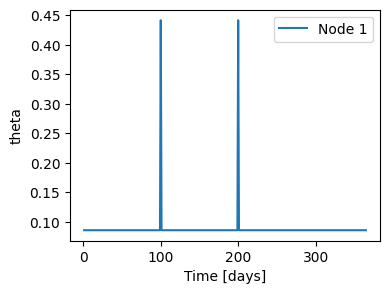

In [213]:
ml.plots.obs_points(data='theta')